In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def get_data(filenames, skiprows=23, normalization=None):
    return np.array([
        AngleData.get_fromfile(dataname, skiprows=skiprows, normalization=normalization) for dataname in filenames
    ])

class AngleData:
    def __new__(self):
        self.name = None
    
    @classmethod
    def get_fromfile(cls, file = None, skiprows = 24, normalization = None):
        angledata = AngleData()
        data = np.loadtxt(file, skiprows=skiprows)
        angledata.value = np.abs(data.mean())
        angledata.std = data.std()
        filename_split = file.split('/')[-1].split('.')
        angledata.angle = np.float64(filename_split[2])*np.pi/180.0 + np.float64(filename_split[3])*np.pi/180.0/100
        angledata.polarization = 's' if int(filename_split[-2]) == 1 else 'p'
        angledata.inverted = True if 'inv' in filename_split else False
        angledata.normalized: bool = False if normalization is None else True
        
        return angledata

class SingleRun:
    def __new__(self):
        self.IDs: np.ndarray = None
        self.reflectance: np.ndarray = None
        self.reflectance_std: np.ndarray = None
        self.angles: np.ndarray
        self.polarization: str = 'both'
    
    @classmethod
    def get_fromadl(cls,data: np.ndarray, normalization: AngleData, polarization: str = None):
        
        norm = normalization
        
        singlerun = SingleRun
        
        if polarization is None:
            singlerun.polarization = data[0].polarization
        else:
            singlerun.polarization = polarization
        
        singlerun.angles = np.array([
            di.angle for di in data
        ])
        
        singlerun.reflectance = np.array([
            di.value/norm.value for di in data
        ])
        
        singlerun.reflectance_std = np.array([
            np.sqrt( (di.std/norm.value)**2  + (di.value * norm.std / norm.value**2)**2 ) for di in data
        ])
        
        singlerun.IDs = np.array([
            di.inverted for di in data
        ])
        
        return singlerun
    
    @classmethod
    def plot(self, plot_asone=False, color='k', markersize=5):
        
        if plot_asone:
            plt.errorbar(self.angles, self.reflectance, yerr=self.reflectance_std, 
                         color=color, ecolor=color, fmt='o', mfc='w', markersize=markersize, label=f'Data ({self.polarization}-plane)')
        else:
            angles = self.angles[self.IDs == False]
            reflectance = self.reflectance[self.IDs == False]
            reflectance_std = self.reflectance_std[self.IDs == False]
            
            angles_inv = self.angles[self.IDs == True]
            reflectance_inv = self.reflectance[self.IDs == True]
            reflectance_std_inv = self.reflectance_std[self.IDs == True]
            
            plt.errorbar(angles, reflectance, yerr=reflectance_std, 
                         color=color, ecolor=color, fmt='o', mfc='w', markersize=markersize, label=f'Data ({self.polarization}-plane, non inverted)')
            
            plt.errorbar(angles_inv, reflectance_inv, yerr=reflectance_std_inv, 
                         color=color, ecolor=color, fmt='^', mfc='w', markersize=markersize, label=f'Data ({self.polarization}-plane, inverted)')
            
            plt.xlabel('Normal incidence angle/rad')
            plt.ylabel('Reflectance/%')
    

In [65]:
import glob
files = glob.glob('../data/test1/**.lvm')
files = sorted(files)


In [66]:

data = np.array([AngleData.get_fromfile(file, 23) for file in files])

In [67]:
s1 = SingleRun.get_fromadl(data, data[0])

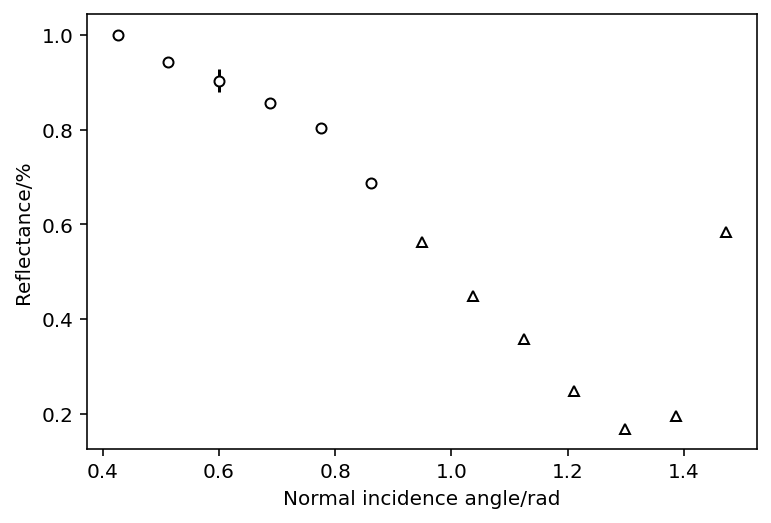

In [62]:
s1.plot()